# Transformer Dose Calculation 

## Import libraries and define auxiliary functions

In [2]:
import h5py
import numpy as np
import random
import math
import json
import sys
sys.path.append('./src')
from models import dota_residual
from generators import DataGenerator
from evaluation import infer, from_file
from plot import plot_slice, plot_beam
import matplotlib.pyplot as plt
%matplotlib inline

## Load hyperparameters, data and model

In [4]:
# Load model and data hyperparameters.
with open("./hyperparam.json", "r") as hfile:
    param = json.load(hfile)

# Prepare input data.
path = "./data/test_plans/"
path_weights = "./weights/ckpt/weights.ckpt"
testIDs = [*range(859)]

# Load normalization constants.
scale = {'y_min':0, 'y_max':3.0755550861358643,
        'r_min':0, 'r_max':3.0755550861358643,
        'x_min':0, 'x_max':4.071000099182129}

transformer = dota_residual(
    inshape=param['inshape'],
    steps=param['num_levels'],
    enc_feats=param['enc_feats'],
    num_heads=param['num_heads'],
    num_transformers=param['num_transformers'],
    kernel_size=param['kernel_size']
)
transformer.summary()

# Load weights from checkpoint.
transformer.load_weights(path_weights)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 96, 64,  0           []                               
                                 1)]                                                              
                                                                                                  
 input_4 (InputLayer)           [(None, 96, 96, 64,  0           []                               
                                 1)]                                                              
                                                                                                  
 concatenate_2 (Concatenate)    (None, 96, 96, 64,   0           ['input_3[0][0]',                
                                2)                                'input_4[0][0]']          

## Evaluate the model on test data

In [ ]:
inputs, prediction, ground_truth = infer(transformer, testIDs[403], path, scale)
plot_beam(inputs, ground_truth, prediction,  gamma_evaluation=False)

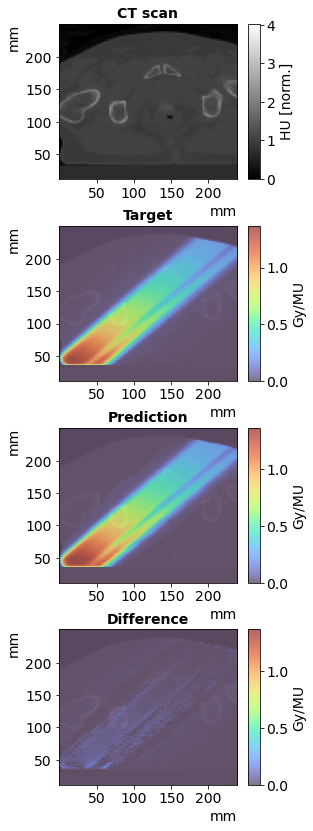

In [7]:
# avg: 519
# worstP : 322
# worstL : 743
inputs, prediction, ground_truth = infer(transformer, testIDs[322], path, scale)
prediction[ground_truth==0] = 0
plot_slice(inputs, ground_truth, prediction, scale, slice_number=32, gamma_slice=False)

In [10]:
from scipy.io import savemat
doses = []
gt_doses = []
testIDs2 = testIDs[600:]
for ID in testIDs2:
    _, prediction, ground_truth = infer(transformer, ID, path, scale)
    prediction[ground_truth==0] = 0
    doses.append(prediction)
    gt_doses.append(ground_truth)
savemat('doses.mat', {'pred':np.array(doses), 'gt':np.array(gt_doses)})